## Imports

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random
import unicodedata
import string
import torch
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch import nn, optim

## Global variables
Change for running configuration

In [2]:
TRAINING_PERCENT = 70
TEST_PERCENT = 20
VIEW_PERCENT = 10
LEARNING_RATE = 0.005  # If you set this too high, it might explode. If too low, it might not learn
EPOCHS = 5000
PRINT_EVERY = 100
PLOT_EVERY = 100
N_HIDDEN = 128
EXEC_MODE = 2
PATH = "models/model.pt"
PATH2 = "models/model2.pt"
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

## Models
### Single hidden layer model

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

### Dual hidden layer model

In [4]:
class MultilayerRnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultilayerRnn, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.h2h(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

### Configuration
Data loading and environment configuration

In [5]:
def find_files(path): return glob.glob(path)


print(find_files('data/products/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


for filename in find_files('data/products/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/products/toys.txt', 'data/products/music.txt', 'data/products/book.txt', 'data/products/smartphone.txt', 'data/products/clothes.txt', 'data/products/food.txt', 'data/products/games.txt', 'data/products/fitness.txt']


## Preparing data

In [6]:
def split_list(l, training, test, view):
    training_list = []
    test_list = []
    view_list = []
    for i in range(0, training):
        index = random.randint(0, len(l) - 1)
        training_list.append(l[index])
        del l[index]

    for i in range(0, test):
        index = random.randint(0, len(l) - 1)
        test_list.append(l[index])
        del l[index]

    for i in range(0, min(view, len(l) - 1)):  # If there are decimals this max allow us to get the items left
        index = random.randint(0, len(l) - 1)
        view_list.append(l[index])
        del l[index]

    return training_list, test_list, view_list


def split_dataset(category_lines, training, test, view):
    training_dict = {}
    test_dict = {}
    view_dict = {}
    for category in category_lines.keys():
        size = len(category_lines[category])
        training_list, test_list, view_list = split_list(category_lines[category],
                                                         int(size * training / 100), int(size * test / 100), int(size * view / 100))
        training_dict[category] = training_list
        test_dict[category] = test_list
        view_dict[category] = view_list

    return training_dict, test_dict, view_dict

training_dataset, test_dataset, view_dataset = split_dataset(category_lines, TRAINING_PERCENT, TEST_PERCENT, VIEW_PERCENT)

## Utils

In [7]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

def category_from_output(all_categories, output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


def save_checkpoint(model, filepath):
    checkpoint = { 'state_dict': model.state_dict()}
    torch.save(checkpoint, filepath)


def load_checkpoint(model, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model


line_to_tensor('Jose Ramón').size()

torch.Size([10, 1, 57])

## Creating RNN

In [8]:
if EXEC_MODE == 1:
    rnn = RNN(n_letters, N_HIDDEN, n_categories)
elif EXEC_MODE == 2:
    rnn = RNN(n_letters, N_HIDDEN, n_categories)
    rnn2 = MultilayerRnn(n_letters, N_HIDDEN, n_categories)
else:
    print("Loading network")
    rnn = RNN(n_letters, N_HIDDEN, n_categories)
    rnn = load_checkpoint(rnn, PATH)
    #rnn.eval()
inputChar = letter_to_tensor('A')

hidden = torch.zeros(1, N_HIDDEN)

rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=8, bias=True)
  (softmax): LogSoftmax()
)

### Getting output

In [9]:
output, next_hidden = rnn(inputChar, hidden)
category_from_output(all_categories, output)

('games', 6)

### Showing samples

In [10]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]


def random_training_example(categories, dataset):
    category = random_choice(categories)
    line = random_choice(dataset[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example(all_categories, training_dataset)
    print('category =', category, '/ line =', line)

category = games / line = XPLANE   AEROSOFT AIRPORT COLLECTION
category = games / line = The Sims   Vida Islena
category = fitness / line = iron dumbbell kg
category = toys / line = crayfomo Twister Game Juego de Suelo Juegos Twister Infantiles
category = games / line = The Sims   Vida Islena
category = music / line = The Katie Melua Collection
category = smartphone / line = LG G ThinQ
category = fitness / line = Nautilus Treadmill Series
category = smartphone / line = Samsung Galaxy Grand Prime
category = food / line = HUEVOS CHOCO MIX LOL U


### Defining criterion
NLLLoss() is good because the last layer of the RNN is nn.LogSoftmax I have to see the different criterion and activation functions

In [11]:
if EXEC_MODE == 1 or EXEC_MODE == 2:
    criterion = nn.NLLLoss()

## Training
each loop of training
  1) Create input and target tensors
  2) Create zeroed initial hidden state
  3) Read each letter in and keep hidden state for next letter
  4) Compare final output to target
  5) Back-propagate
  6) Return to output and loss
Keep track of losses for plotting

In [12]:
def train(model, category_tensor, line_tensor, criterion, learning_rate):
    hidden = model.init_hidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


def train_loop(model, criterion, categories, dataset, epochs,  learning_rate, print_every, plot_every):
    current_loss = 0
    all_losses = []

    # optimizer = optim.SGD(rnn.parameters(), lr=LEARNING_RATE)

    def time_since(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    for iter in range(1, epochs + 1):
        model.zero_grad()
        category, line, category_tensor, line_tensor = random_training_example(categories, dataset)
        output, loss = train(model, category_tensor, line_tensor, criterion, learning_rate)
        current_loss += loss
        # optimizer.step()
        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(categories, output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' %
                  (iter, iter / epochs * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return model, all_losses



if EXEC_MODE == 1:
    print("Training network")
    rnn, all_losses = train_loop(rnn, criterion, all_categories, training_dataset, EPOCHS, LEARNING_RATE, PRINT_EVERY, PLOT_EVERY)
if EXEC_MODE == 2:
    print("Training first network")
    rnn, all_losses = train_loop(rnn, criterion, all_categories, training_dataset, EPOCHS, LEARNING_RATE, PRINT_EVERY, PLOT_EVERY)
    print("Training second network")
    rnn2, all_losses2 = train_loop(rnn2, criterion, all_categories, training_dataset, EPOCHS, LEARNING_RATE, PRINT_EVERY, PLOT_EVERY)

Training first network
100 2% (0m 0s) 2.1578 crayfomo Twister Game Juego de Suelo Juegos Twister Infantiles / fitness ✗ (toys)
200 4% (0m 2s) 1.9732 The Predator / music ✓
300 6% (0m 3s) 2.1208 Samsung Galaxy Grand Prime / fitness ✗ (smartphone)
400 8% (0m 4s) 2.0373 Trap Lord / games ✗ (music)
500 10% (0m 5s) 2.0113 Boombox , Early Independent Hip Hop, Electro And Disco Rap  lp Vinilo / toys ✗ (music)
600 12% (0m 7s) 1.9111 Joma Drive Bermuda Deporte, Hombre / clothes ✓
700 14% (0m 8s) 2.0807 LG G / fitness ✗ (smartphone)
800 16% (0m 9s) 1.7392 Gourmet Maiz Dulce en Grano  Envasado al Vacio   g / food ✓
900 18% (0m 10s) 2.1355 iron dumbbell kg / food ✗ (fitness)
1000 20% (0m 11s) 2.0562 Hearts Of Iron IV / food ✗ (games)
1100 22% (0m 12s) 2.0038 Panasonic P / food ✗ (smartphone)
1200 24% (0m 13s) 2.0439 TWISTER  Manta de Picnic, diseno de Juego Twister / fitness ✗ (toys)
1300 26% (0m 14s) 2.0067 Football Manager  / toys ✗ (games)
1400 28% (0m 15s) 1.7061 LEVADURA SECA x G / food ✓
150

## Plotting info
1. One plot is a square of classes, in every square is represented the
index of times is predicted one class when it's the other
It's good to be yellow on diagonal
2. The other is de function loss progression

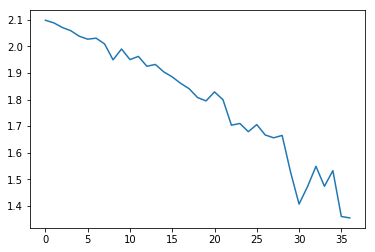

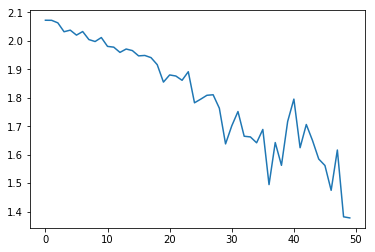

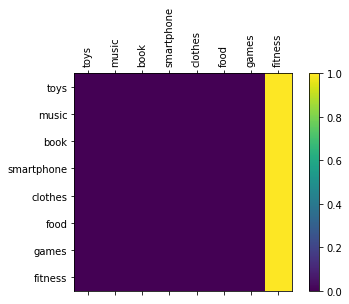

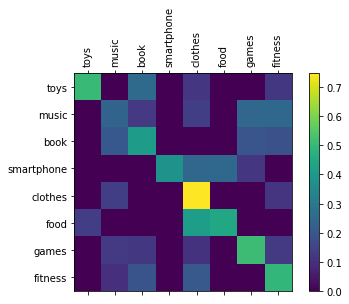

In [13]:
def evaluate(model, line_tensor):
    hidden = model.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output


def predict(model, input_line, all_categories, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(model, line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


def test_with_plot(model, dataset, categories):
    n_categories = len(categories)
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = random_training_example(categories, dataset)
        output = evaluate(model, line_tensor)
        guess, guess_i = category_from_output(categories, output)
        category_i = categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()

    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


if EXEC_MODE == 1 or EXEC_MODE == 2:
    plt.figure()
    plt.plot(all_losses)
if EXEC_MODE == 2:
    plt.figure()
    plt.plot(all_losses2)

test_with_plot(rnn, test_dataset, all_categories)
if EXEC_MODE == 2:
    test_with_plot(rnn2, test_dataset, all_categories)

## Saving and Loading
Saving and Loading model functions

In [14]:
save_checkpoint(rnn, PATH)
if EXEC_MODE == 2:
    save_checkpoint(rnn2, PATH2)

### Some predicts

In [15]:
for key in view_dataset.keys():
    for value in view_dataset[key]:
        predict(rnn, value, all_categories, 3)


> Hasbro Gaming Don't Step In It Unorne  Juego de Mesa con Texto en frances
(nan) book
(nan) music
(nan) fitness

> Falomir Coloca  Juego de Mesa, Multicolor, unica 
(nan) book
(nan) music
(nan) fitness

> Mattel Games UNO classic, juego de cartas Mattel W
(nan) book
(nan) music
(nan) fitness

> One More Light
(nan) book
(nan) music
(nan) fitness

> Black Pumas Vinilo
(nan) book
(nan) music
(nan) fitness

> ASTROWORLD Explicit
(nan) book
(nan) music
(nan) fitness

> Hold On I'm Coming  gm vinyl Vinilo
(nan) book
(nan) music
(nan) fitness

> The Adventures of Huckleberry Finn
(nan) book
(nan) music
(nan) fitness

> Pride and Prejudice
(nan) book
(nan) music
(nan) fitness

> Nokia  PureView
(nan) book
(nan) music
(nan) fitness

> HTC Magic
(nan) book
(nan) music
(nan) fitness

> HTC Dream
(nan) book
(nan) music
(nan) fitness

> Adidas Regista   Pantalones de futbol para Hombre
(nan) book
(nan) music
(nan) fitness

> Nike Yth Park Ii Knit Short Nb, Pantalon Corto, Ninos
(nan) book
(nan) 